# Did lyrics become more homogenous over time?

**Progetto per il corso di Economia dei Network**
**Università di Cagliari**

**Emanuele Porcu**

e.porcu36@studenti.unica.it - porcu.emanuele@gmail.com

# Introduction

With the advent of streaming platforms, such as Spotify, Amazon Music or Youtube Music, to cite a few, the music industry has gone through a profound change in the way people share and listen to music. Such a switch in music fruition impacted also how music is released; artists tend, indeed, to put out music more frequently than in the past and to release primarily singles, rather than albums. At the same time, in the last two decades music composition has become progressively more repetitive[5]. Mainstream music showed the tendency to adopt similar chord progressions and similar arrangements, likely in the attempt to reiterate successful music formulas and improve the chances to hit the top of the charts. 

In this project I try to understand whether this phenomenon is confined to music composition or it extends also to lyrics. Specifically, the project investigates whether patterns of frequently co-occurring words are increasingly more present in mainstream music, or whether this not actually the case.

To this end, I follow three main steps:

1. Extraction of words frequently used in mainstream music, via topic modeling, in seven major musical genres: pop, country, blues, jazz, reggae, rock and hip hop.
2. Creation of networks of frequent words present in each lyrics of a given genre.
3. Comparison between networks over the years by using several established methods.

The underlying rationale is that if similar networks of co-occurring words are being adopted, such networks will be more similar to each other over time. 
Furthermore, the project aims at investigating whether different genres might show different behaviors given the nature more or less conservative of music genres (such as country or blues).

Additionally, in the last part of the project, I aim at assessing whether word similarity might have any economical impact. I test the potential relationship between lyrics similarity and songs popularity on the Spotify charts.


# Previous work

The majority of studies focused on musical composition or on other aspects of mainstream lyrics rather than the homogeneity across lyrics. The most relevant studies directly tackling lyrics similarity [7, 4] investigated how complexity/simplicity and repetitiveness are distributed in mainstream lyrics. On the one hand, both studies suggest a certain trend toward repetitiveness through times and across genres. Lyrics complexity, on the other hand, resulted to be highly variable. None of the aforementioned studies adopted a network approach.

In [1]:
#%matplotlib notebook

from itertools import combinations
from os.path import join

from network_utils import create_nets, min_max, get_networks, balance_df, is_in_lyrics, NetComparison
from plotting_utils import plot_dissmat, plot_network, plot_similarity
from topic_modeling import TopicModeling

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import netrd
import pandas as pd
import ruptures as rpt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import permutation_test, kruskal, ranksums
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split


# The dataset

The data used in the project come from a public dataset called *Music Dataset: Lyrics and Metadata from 1950 to 2019* [6].
The dataset is quite rich, it contains 28372 songs in English, released between 1950 and 2019. It includes a number of features such as: artist name, track name, release date, genre (pop, rock, jazz, reggae, country, blues and hip hop), full lyrics and many others (see cell below).

In [2]:
df = pd.read_csv("tcc_ceds_music.csv").drop(columns='Unnamed: 0')
df.head()

,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,night/time,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,mukesh,mohabbat bhi jhoothi,1950,pop,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.997992,0.901822,0.339448,0.137110,sadness,1.0
1,frankie laine,i believe,1950,pop,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,0.001284,...,0.001284,0.001284,0.331745,0.647540,0.954819,0.000002,0.325021,0.263240,world/life,1.0
2,johnnie ray,cry,1950,pop,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.840361,0.000000,0.351814,0.139112,music,1.0
3,pérez prado,patricia,1950,pop,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.083935,0.199393,0.775350,0.743736,romantic,1.0
4,giorgos papadopoulos,apopse eida oneiro,1950,pop,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,0.001350,...,0.068800,0.001350,0.291671,0.646489,0.975904,0.000246,0.597073,0.394375,romantic,1.0


# Methods

## Dataset preprocessing

Prior to the data analysis, the dataset went through a very light preprocessing, which consisted of 
removing any of the features unnecessary for the purpose of the project. Only the following features were kept: 
`artist_name, track_name, release_date, genre, lyrics`. 
Furthermore, the dataset was checked for any missing data points.
Lyrics have not been further preprocessed given that were provided in a cleaned form (stop-words, punctuation or any irrelevant character had been already removed).


In [3]:
# remove irrelevant columns
df = df[["artist_name", "track_name", "release_date", "genre", "lyrics"]]

# reports number of NaNs and percentage of NaNs
NaNs = pd.DataFrame({"number_of_nan": df.isna().sum(),
            "perc_of_nan": df.isna().sum() / len(df) * 100})

## Topic modeling: Extraction of frequently used words

In order to identify the most frequently used words, a topic modeling approach was preferred to simpler approaches, such as counting words occurrence within the corpus of lyrics. 
Topic modeling should in principle guarantee a broader diversity in the chosen words and produce a more representative set of topics. I adopted a well established topic modeling method: Latent Dirichlet Allocation (LDA), which was performed by using the python library `scikit-learn 1.2.2` and custom made routines.
LDA was applied to a corpus of lyrics subdivided by genre. 
To reduce the potential bias due to an over-representation of specific periods (some years included more songs than others), prior to the LDA, I made sure that the number of songs per year was uniformly distributed.
The new distribution was obtained by randomly selecting a number of songs in each year equal to the median of the number of songs over the years (for a given genre). 
The median was considered a good trade off between having too few songs versus many release dates and many songs versus few release dates.
LDA parameters were empirically tuned (see cell below) and no automatic gridsearch approach was employed; to keep the set of chosen words small, I produced 10 topics from which I selected the first 5 highest weighted words. The LDA was performed separately for each genres, resulting in seven distinct topic modeling, one per genre (see results below).

In [4]:
# global variables for LDA

MAX_DF = 0.95
MIN_DF = 10 # if int means absolute count of word fequency in a corpus
N_FEAT = 1000
COMPONENTS = 10
N_TOP_WORDS = 5
MAX_ITER = 5

# The following code runs a topic modeling for each genre and collects words in a dictionary
# with genres as keys and set of words as values. 
# It also collects the dataframe (to construct the networks) 
# for each genre balanced by number of songs per year.

WORDS_DICT, BALANCED_DF = {}, {}
for genre in df.genre.unique():
    BALANCED_DF[genre] = balance_df(df, genre, balance=True)
    TP = TopicModeling(MAX_DF, MIN_DF, N_FEAT)
    WORDS_DICT[genre] = TP(BALANCED_DF[genre].lyrics, COMPONENTS, N_TOP_WORDS, MAX_ITER)
    print(genre)
    print(WORDS_DICT[genre])
    print("----------------")

pop
{'hold', 'night', 'play', 'life', 'better', 'wish', 'yeah', 'breathe', 'sing', 'wanna', 'home', 'hear', 'heart', 'cold', 'long', 'bring', 'live', 'like', 'want', 'gonna', 'drop', 'inside', 'fuck', 'world', 'money', 'feel', 'listen', 'line', 'sweet', 'things', 'head', 'bleed', 'song', 'right', 'good', 'happen', 'away', 'come', 'days', 'time', 'fall', 'pull', 'leave', 'know', 'blue', 'straight'}
----------------
country
{'hurt', 'shelter', 'cause', 'night', 'play', 'change', 'life', 'lonesome', 'yeah', 'ready', 'tonight', 'break', 'sing', 'home', 'hear', 'heart', 'bout', 'hand', 'memory', 'long', 'like', 'gonna', 'fool', 'thing', 'baby', 'line', 'hero', 'rain', 'texas', 'right', 'song', 'songs', 'good', 'remember', 'away', 'rockin', 'time', 'leave', 'walk', 'know', 'round', 'blue'}
----------------
blues
{'fever', 'hold', 'night', 'fail', 'play', 'life', 'better', 'yeah', 'bother', 'sing', 'black', 'hear', 'save', 'wire', 'believe', 'heart', 'blood', 'alive', 'hand', 'long', 'follow'

## Network creation

Network creation was based on the following simple rules: 


- If a word from the set of frequent words is present in a song, that word becomes a vertex.
- If two words (vertices) belong to the same song an edge between these two vertices is created. 
- Weights are simply the number of times two nodes co-occur in the songs considered for a network.

Given that the scope of the project was to perform separate analyses for each genre, I created a network for each year, hence resulting in seven time series of networks, as many as the number of genres.
Network size and time series were variable given that some genre were over-represented (e.g. pop) and other were scarcely represented (e.g. hip hop).
Networks' plots and related analysis were done by using the python libraries `Networkx 3.1` and `netdr 0.1`[8, 9], plus custom made routines. 

## Network comparison

Network comparison constitutes an vast area of study which includes a big variety of methods[3, 9], for the current project I have focused on two specific methods: normalized laplacian spectrum[1] and protrait divergence[2]. Both methods did not imply node correspondence (given that through the years nodes could be different). The normalized laplacian spectrum is based on spectral analysis and Euclidean distance while the portrait divergence compares the distribution of two graphs by using the Jensen-Shannon divergence.


## Statistics

To statistically test whether any of the time series showed specific patterns in the similarity/dissimilarity between lyrics, I used two main steps: 
- For each time series I identified any relevant break points (points characterized by an abrupt change) that led to a stable pattern with at least 10 successive data points (I chose 10 points to allow any meaningful statistics). The break points were assessed using the PELT algorithm (Pruned Exact Linear Time) from the python library `ruptures 1.1.7` [10]. 
- As second step, when a meaningful break point was identified, I ran a paired permutation test (given the non-normality of the data) between the identified pattern and the time period immediately preceding the break point. If no meaningful pattern was observed no statistics was performed (as noted after each network comparison, see each relative cell).


This procedure was applied to each genres and each network comparison method separately.
In order to test whether there was any general difference among genre similarity, I ran a Kruskal Wallis test between the times series of each genres, a distinct test per comparison method. To further investigate difference among genres, I run Wilcoxon runksums as post-hoc tests for all the combinations of genre; to adjust for family wise error, p-values were corrected using the Bonferroni correction. All statistics were performed by using the python library `scipy 1.10.1`. 

# Results


## Pop network

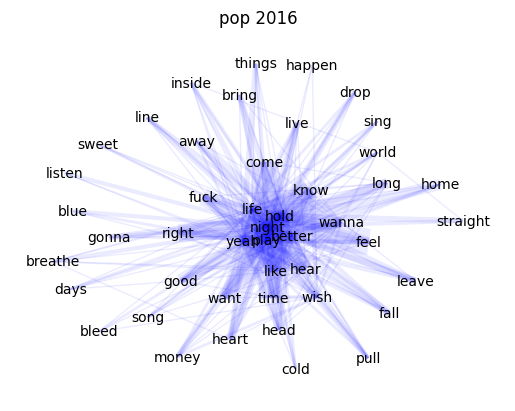

In [5]:
POP_NET = get_networks(BALANCED_DF["pop"], WORDS_DICT["pop"])
plot_network(POP_NET[2016], "pop 2016")

**Figure 1:** It depicts network for the year 2016 from the pop time series. Weights are represented by the width of the edges

### Comparisons between networks

running laplacian method
running portrait_div method


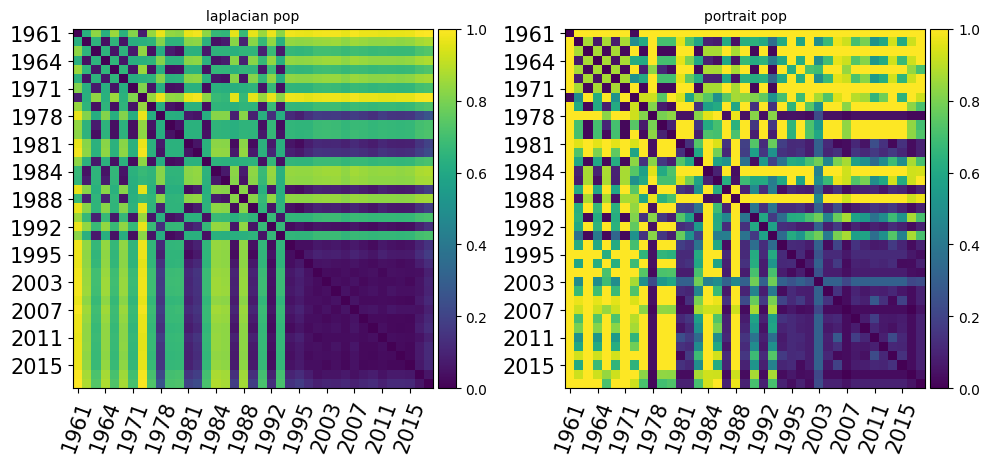

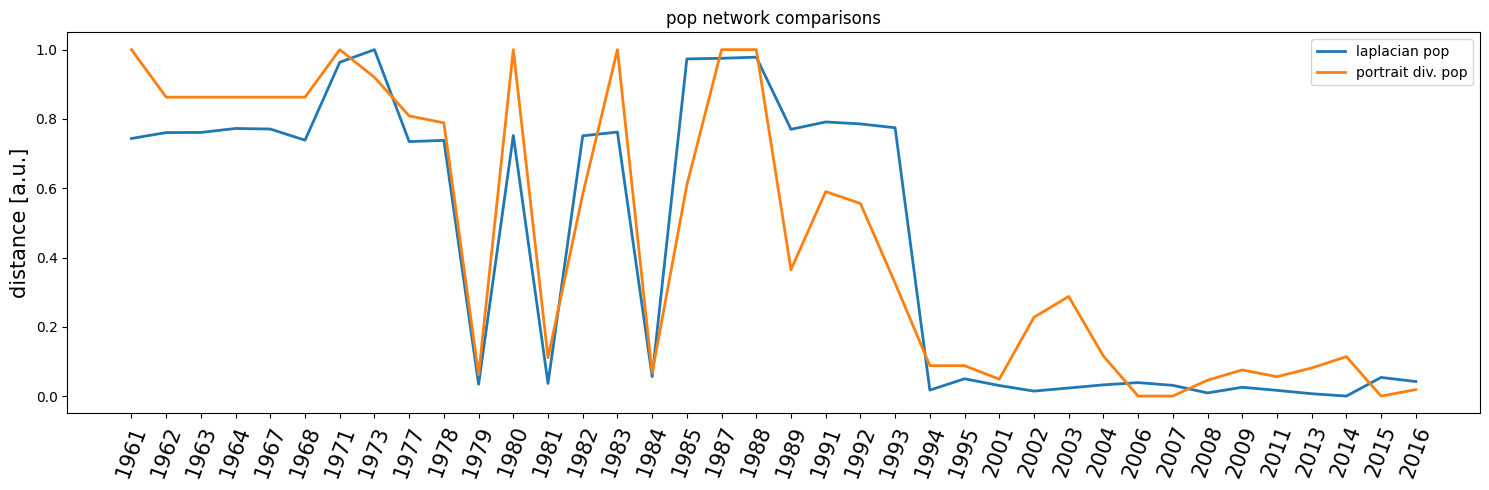

In [6]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(POP_NET, method=method)() for method in METHODS}
POP_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian pop", "portrait pop"], list(POP_NET.keys()))

plot_similarity([
                 min_max(POP_TS["laplacian"], a=0, b=1),
                 min_max(POP_TS["portrait_div"], a=0, b=1),
                ],
                 list(POP_NET.keys())[:-1],
                 "pop network comparisons",
                 ["laplacian pop", "portrait div. pop"]
               )


**Figure 2:** It depicts pairwise distance between pop networks for laplacian spectrum and portrait divergence.

**Figure 3:** It represents the time series distance for pop networks.

In [7]:
TS = np.array([np.diagonal(DIST[method], offset=-1) for method in METHODS])
TS = np.reshape(TS, [TS.shape[1], TS.shape[0]])               
algo = rpt.Pelt(model="rbf").fit(TS)
result = algo.predict(pen=0.1)
print(f"Indices of break points: {result}")

Indices of break points: [5, 10, 15, 20, 25, 30, 38]


In [8]:
BREAK_P = 25

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

for method in METHODS:
    TS1 = np.diagonal(DIST[method], offset=-1)[BREAK_P:]
    TS2 = np.diagonal(DIST[method], offset=-1)[BREAK_P-len(TS1):BREAK_P] 
    print(permutation_test((TS1, TS2), statistic, permutation_type='samples'))
    

PermutationTestResult(statistic=-1.2081034665337533, pvalue=0.001953125, null_distribution=array([-1.20810347, -1.20549813, -1.22007168, ...,  1.22007168,
        1.20549813,  1.20810347]))
PermutationTestResult(statistic=-0.3949089115777568, pvalue=0.00048828125, null_distribution=array([-0.39490891, -0.38462575, -0.38185051, ...,  0.38185051,
        0.38462575,  0.39490891]))


### Results for pop

As evident in the figures 2 and 3, pop time series shows a striking difference between the middle of the nineties and the previous decades. There is, indeed, a significantly higher similarity in both comparison methods (for both p < 0.01) starting from the year 1994 until 2016 as compared to the preceding years.

## Jazz network

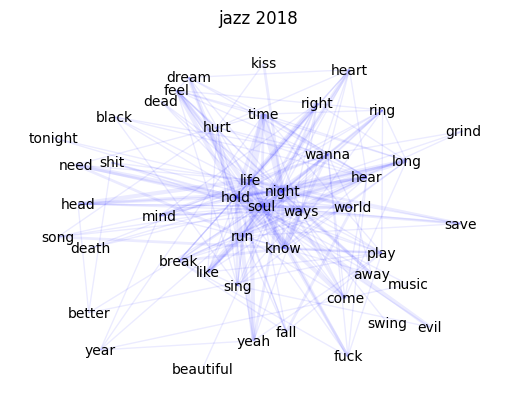

In [9]:
JAZZ_NET = get_networks(BALANCED_DF["jazz"], WORDS_DICT["jazz"])
plot_network(JAZZ_NET[2018], "jazz 2018")

**Figure 4:** It depicts network for the year 2018 from the jazz time series. Weights are represented by the width of the edges

### Comparison between networks

running laplacian method
running portrait_div method


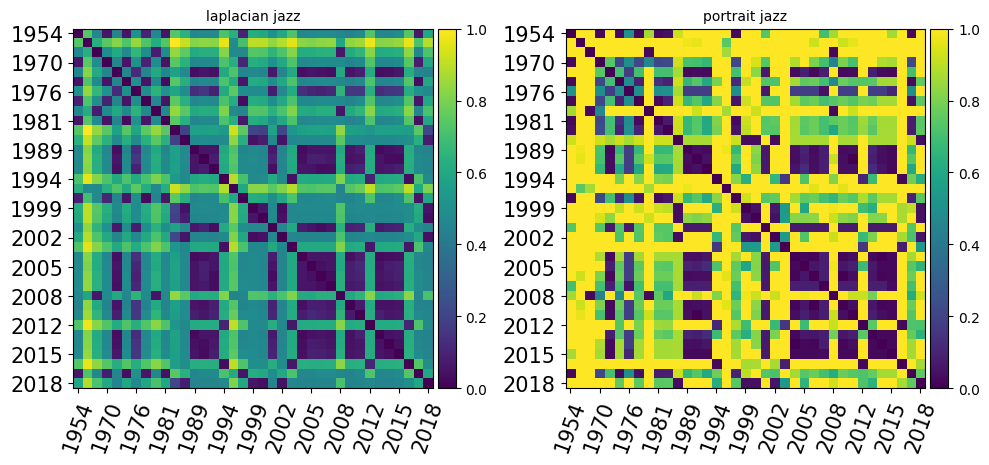

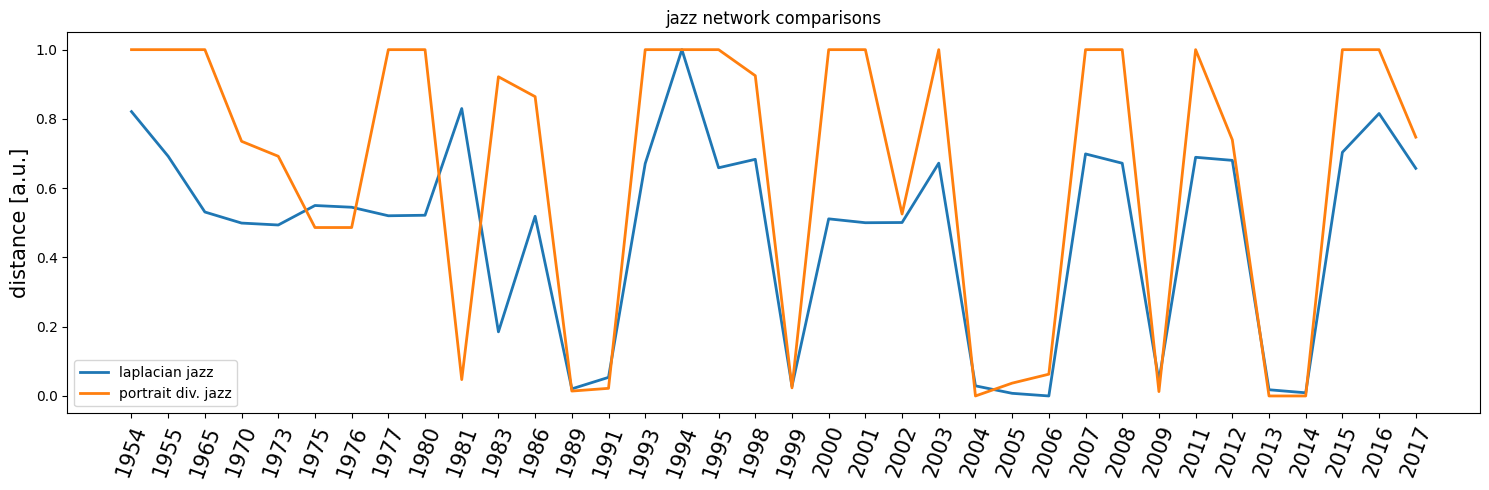

In [10]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(JAZZ_NET, method=method)() for method in METHODS}
JAZZ_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian jazz", "portrait jazz"], list(JAZZ_NET.keys()))

plot_similarity([
                 min_max(JAZZ_TS["laplacian"], a=0, b=1),
                 min_max(JAZZ_TS["portrait_div"], a=0, b=1)
                ],
                 list(JAZZ_NET.keys())[:-1],
                 "jazz network comparisons",
                 ["laplacian jazz", "portrait div. jazz"]
               )


**Figure 5:** It depicts pairwise distance between jazz networks for laplacian spectrum and portrait divergence.

**Figure 6:** It represents the time series distance for jazz networks.

### Results for jazz

The jazz networks have not shown any stable pattern, hence no further statistics was performed on the specific time series. However, both dissimilarity matrices (see Figure 5) relative to the laplacian and portrait divergence methods show several points in time in which similarity was increased, such as the period between 1954 and 1980. 

## Country network

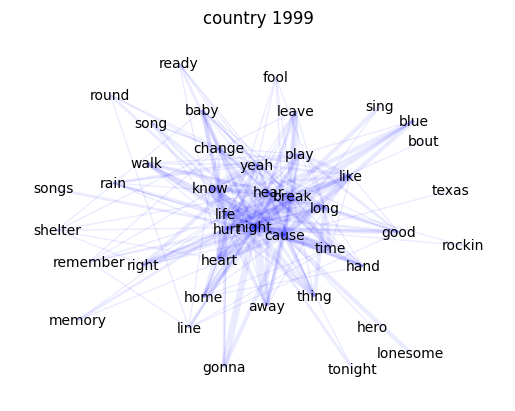

In [11]:
COUNTRY_NET = get_networks(BALANCED_DF["country"], WORDS_DICT["country"])
plot_network(COUNTRY_NET[1999], "country 1999")

**Figure 7:** It depicts network for the year 1999 from the country time series. Weights are represented by the width of the edges

### Comparison between networks

running laplacian method
running portrait_div method


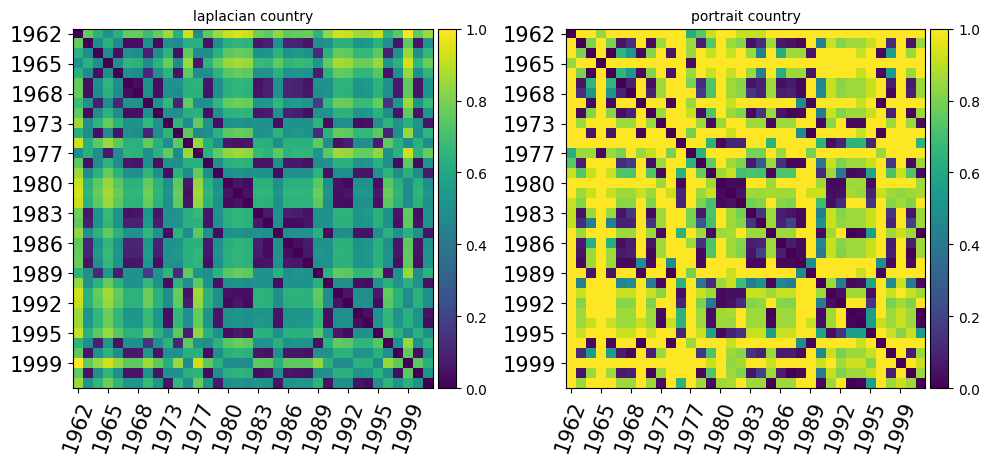

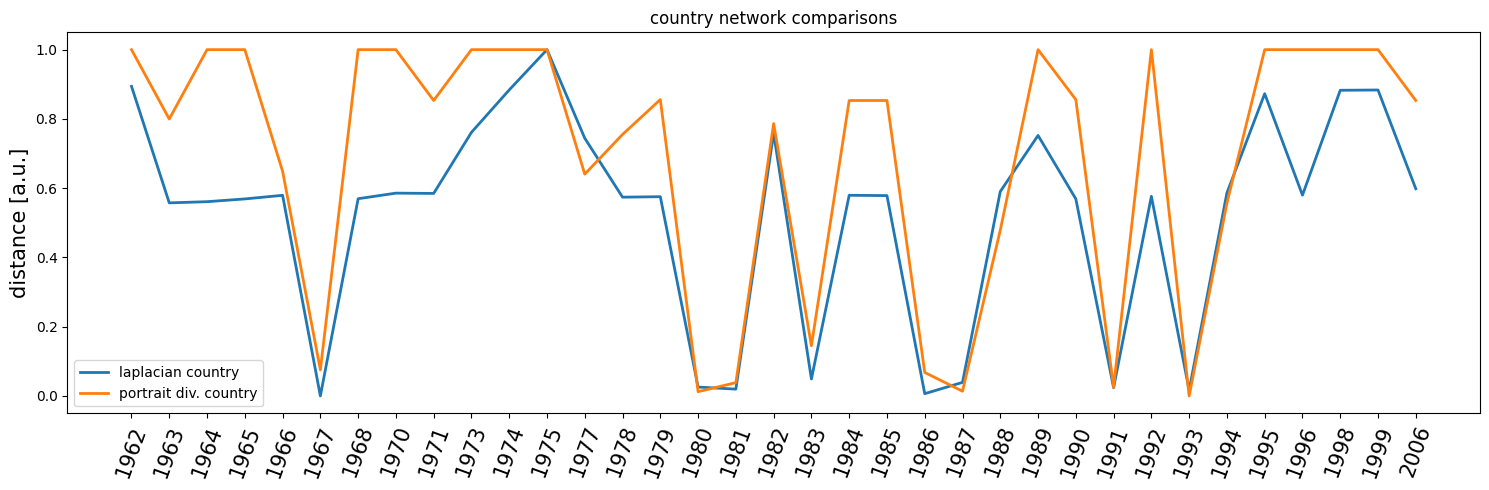

In [12]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(COUNTRY_NET, method=method)() for method in METHODS}
COUNTRY_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian country", "portrait country"], 
             list(COUNTRY_NET.keys()))

plot_similarity([
                 min_max(COUNTRY_TS["laplacian"], a=0, b=1),
                 min_max(COUNTRY_TS["portrait_div"], a=0, b=1)
                ],
                 list(COUNTRY_NET.keys())[:-1],
                 "country network comparisons",
                 ["laplacian country", "portrait div. country"]
               )

**Figure 8:** It depicts pairwise distance between country networks for laplacian spectrum and portrait divergence.

**Figure 9:** It represents the time series distance for country networks.

### Results for country

The country time series does not show any stable pattern (see Figure 9), but a rather noisy fluctuation. Hence no further statistics was performed on the specific time series. Also the two dissimilarity matrices do not show recognizable patterns.

## Reggae network

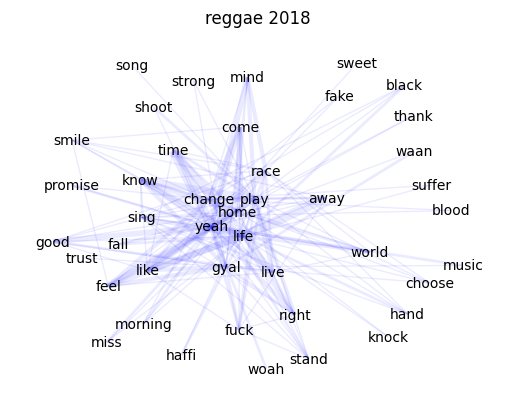

In [13]:
REGGAE_NET = get_networks(BALANCED_DF["reggae"], WORDS_DICT["reggae"])
plot_network(REGGAE_NET[2018], "reggae 2018")

**Figure 10:** It depicts network for the year 2018 from the reggae time series. Weights are represented by the width of the edges

### Comparison between networks

running laplacian method
running portrait_div method


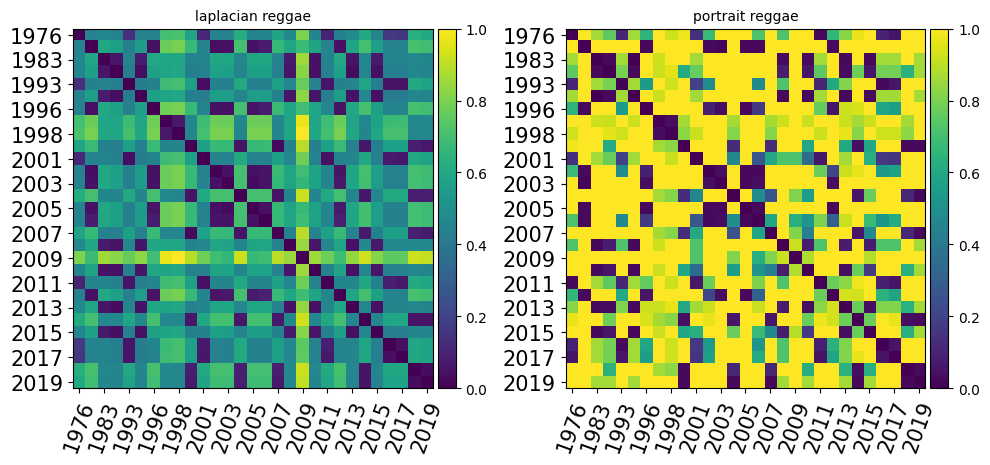

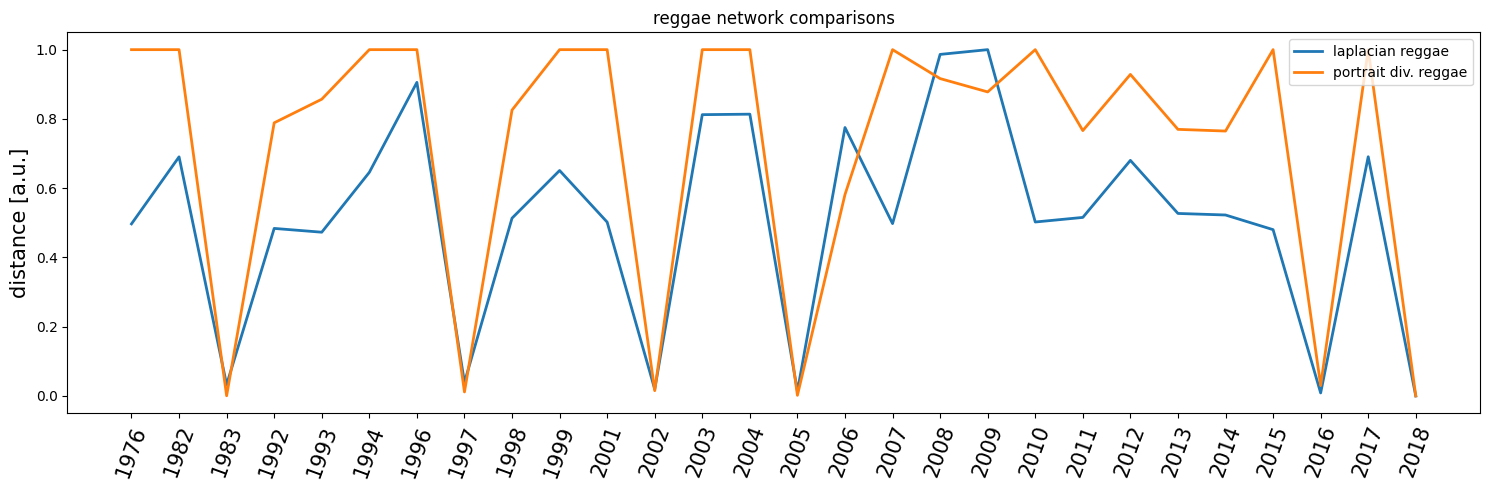

In [14]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(REGGAE_NET, method=method)() for method in METHODS}
REGGAE_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian reggae", "portrait reggae"], 
             list(REGGAE_NET.keys()))

plot_similarity([
                 min_max(REGGAE_TS["laplacian"], a=0, b=1),
                 min_max(REGGAE_TS["portrait_div"], a=0, b=1)
                ],
                 list(REGGAE_NET.keys())[:-1],
                 "reggae network comparisons",
                 ["laplacian reggae", "portrait div. reggae"]
               )

**Figure 11:** It depicts pairwise distance between reggae networks for laplacian spectrum and portrait divergence.

**Figure 12:** It represents the time series distance for reggae networks.

### Results for reggae

Also in the case of reggae, the comparison among networks has not shown any stable pattern. Hence no further statistics was performed on the specific time series. Taking a look at the two dissimilarity matrices, it is possible to identify only a few short periods characterized by higher similarity (e.g. 1976-1996).

## Hip hop network

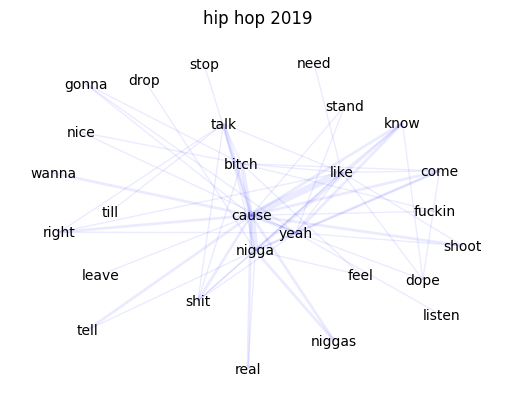

In [15]:
HIP_HOP_NET = get_networks(BALANCED_DF["hip hop"], WORDS_DICT["hip hop"])
plot_network(HIP_HOP_NET[2019], "hip hop 2019")

**Figure 13:** It depicts network for the year 2019 from the hip hop time series. Weights are represented by the width of the edges

### Comparison between networks

running laplacian method
running portrait_div method


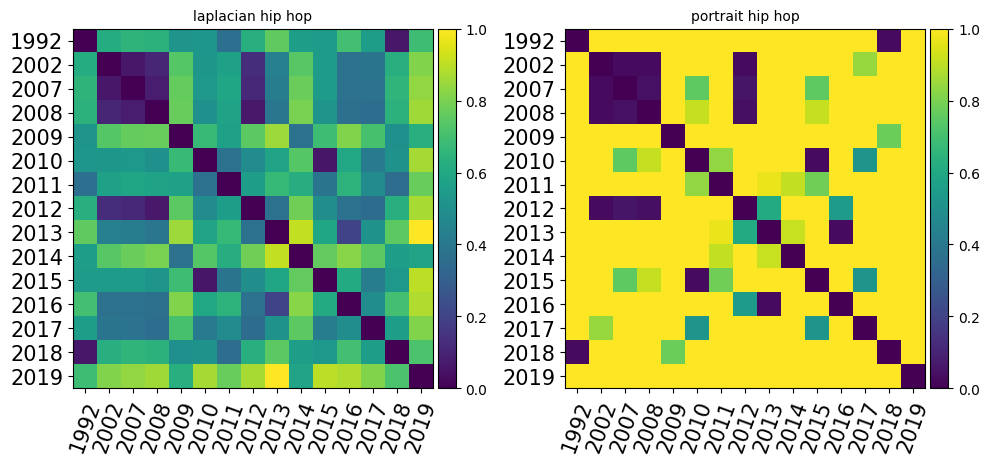

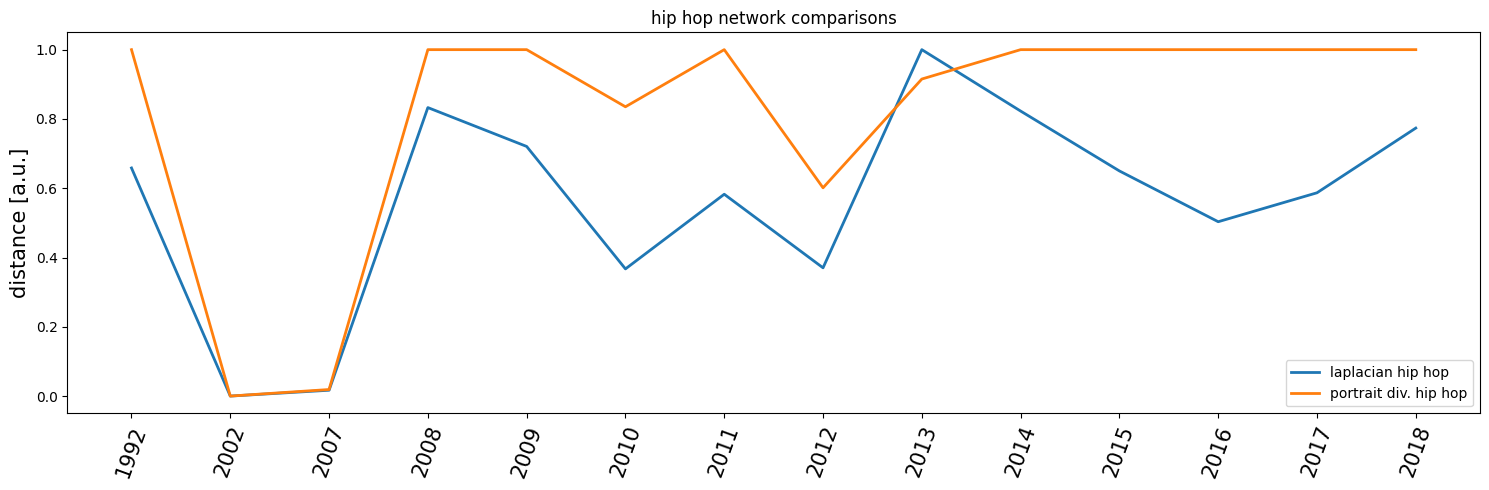

In [16]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(HIP_HOP_NET, method=method)() for method in METHODS}
HIP_HOP_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian hip hop", "portrait hip hop"], 
             list(HIP_HOP_NET.keys()))

plot_similarity([
                 min_max(HIP_HOP_TS["laplacian"], a=0, b=1),
                 min_max(HIP_HOP_TS["portrait_div"], a=0, b=1)
                ],
                 list(HIP_HOP_NET.keys())[:-1],
                 "hip hop network comparisons",
                 ["laplacian hip hop", "portrait div. hip hop"]
               )

**Figure 14:** It depicts pairwise distance between hip hop networks for laplacian spectrum and portrait divergence.

**Figure 15:** It represents the time series distance for hip hop networks.

### Results for hip hop

After balancing the number of songs across the years, the hip hop time series resulted in a low number of data points, which made hard to draw reliable conclusions on the hip hop results. No further statistics was performed, however hip hop data were still included in the overall statistics that compared the time series across genres (see section 6.8: Comparison across genres).


## Rock network

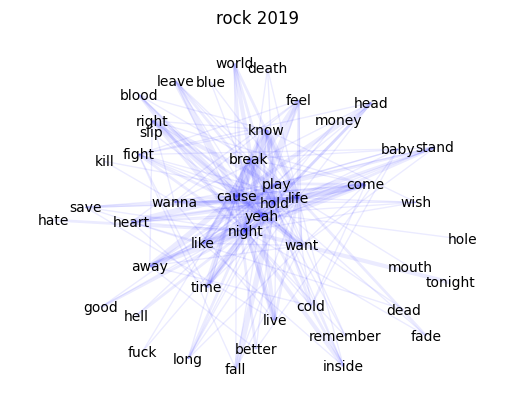

In [17]:
ROCK_NET = get_networks(BALANCED_DF["rock"], WORDS_DICT["rock"])
plot_network(ROCK_NET[2019], "rock 2019")

**Figure 16:** It depicts network for the year 2019 from the rock time series. Weights are represented by the width of the edges

### Comparison between networks

running laplacian method
running portrait_div method


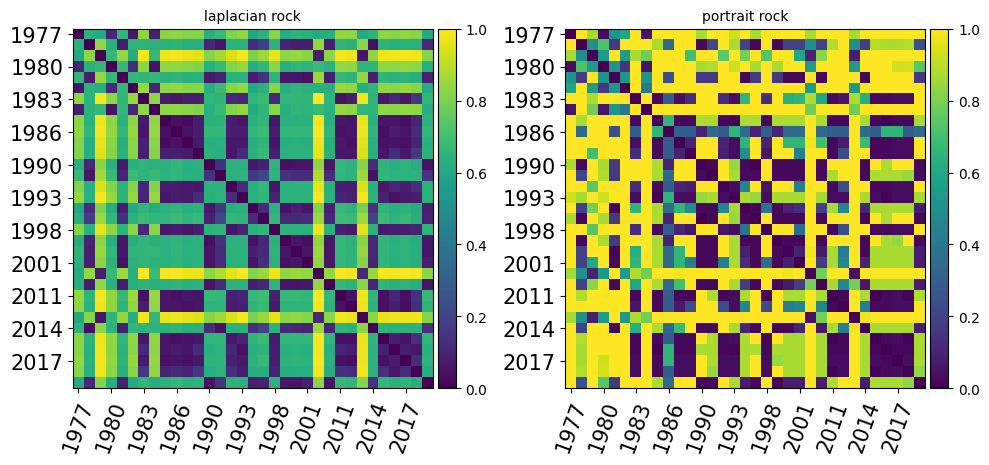

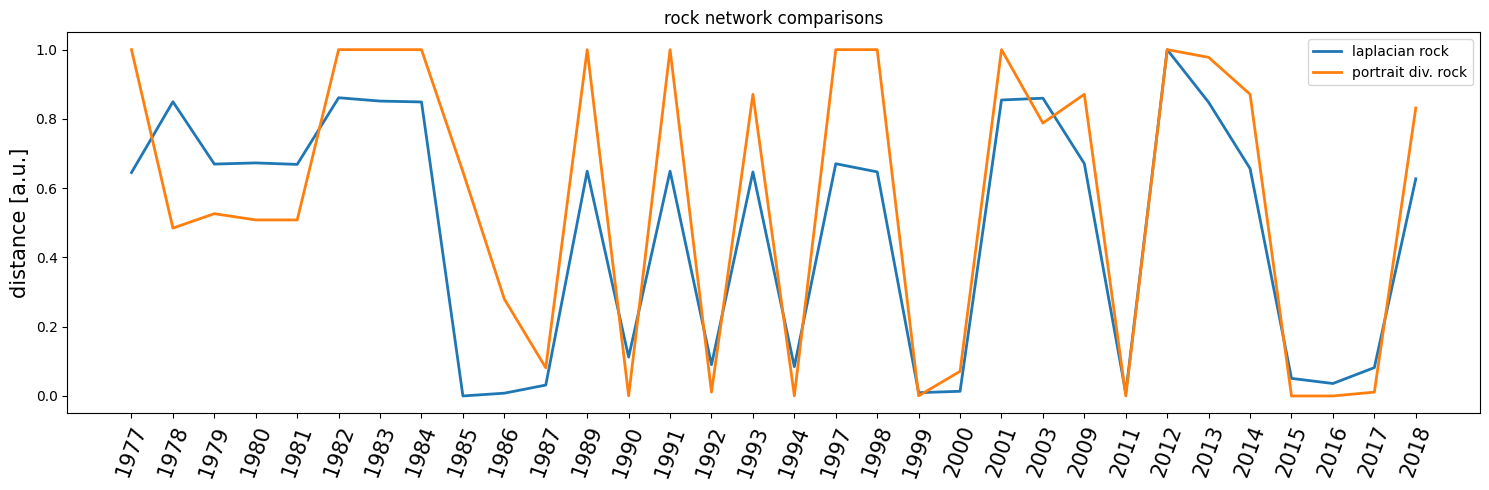

In [18]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(ROCK_NET, method=method)() for method in METHODS}
ROCK_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian rock", "portrait rock"], 
             list(ROCK_NET.keys()))

plot_similarity([
                 min_max(ROCK_TS["laplacian"], a=0, b=1),
                 min_max(ROCK_TS["portrait_div"], a=0, b=1)
                ],
                 list(ROCK_NET.keys())[:-1],
                 "rock network comparisons",
                 ["laplacian rock", "portrait div. rock"]
               )

**Figure 17:** It depicts pairwise distance between rock networks for laplacian spectrum and portrait divergence.

**Figure 18:** It represents the time series distance for rock networks.

### Results for rock

As visible in figure 17, a pattern of higher similarity seems to arise between 1984 and 2000. However, the rock networks do not show any stable pattern in both methods. Hence no further statistics was performed. 

## Blues Network

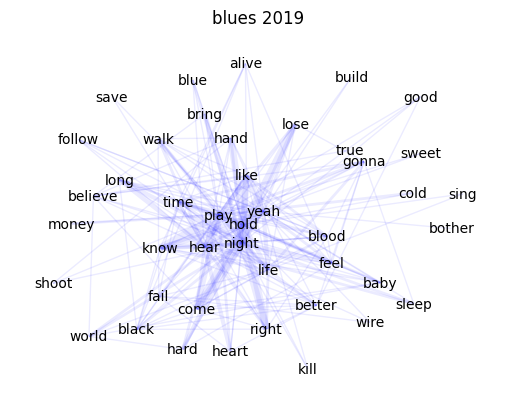

In [19]:
BLUES_NET = get_networks(BALANCED_DF["blues"], WORDS_DICT["blues"])
plot_network(BLUES_NET[2019], "blues 2019")

**Figure 19:** It depicts network for the year 2019 from the blues time series. Weights are represented by the width of the edges

### Comparison between networks

running laplacian method
running portrait_div method


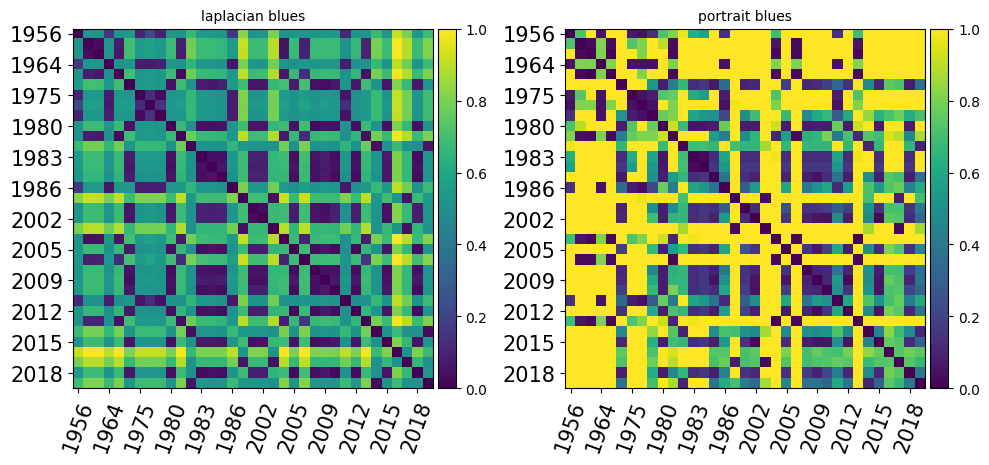

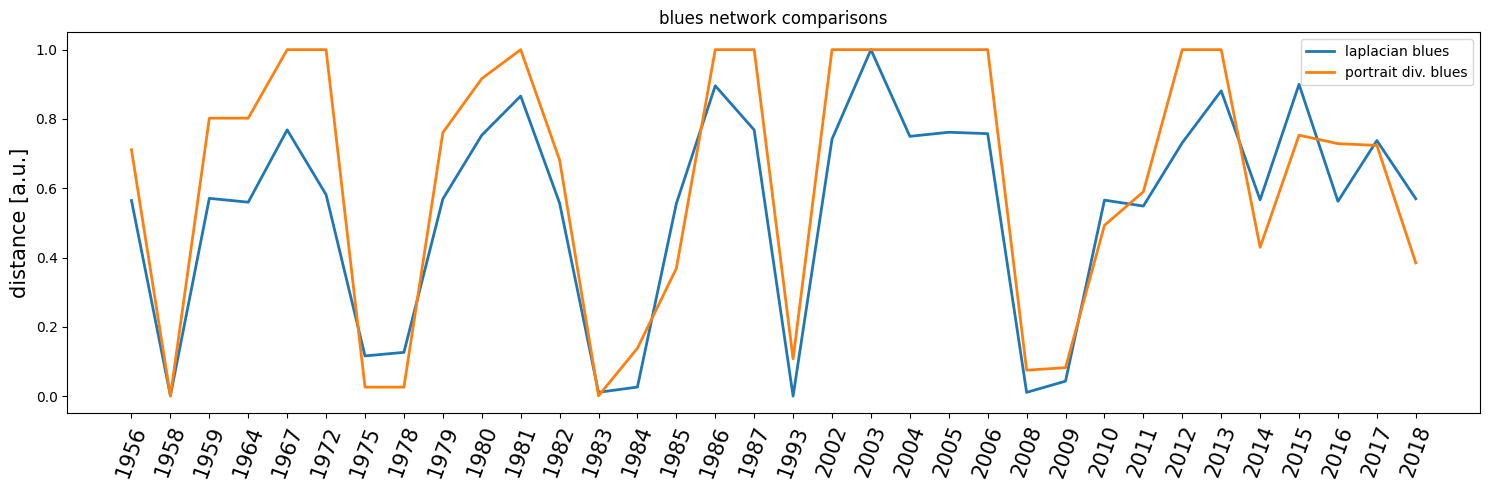

In [20]:
METHODS = ["laplacian", "portrait_div"]
DIST = {method: NetComparison(BLUES_NET, method=method)() for method in METHODS}
BLUES_TS = {method: np.diagonal(DIST[method], offset=-1) for method in METHODS}

plot_dissmat([min_max(DIST["laplacian"], a=0, b=1), min_max(DIST["portrait_div"], a=0, b=1)], 
             ["laplacian blues", "portrait blues"], 
             list(BLUES_NET.keys()))

plot_similarity([
                 min_max(BLUES_TS["laplacian"], a=0, b=1),
                 min_max(BLUES_TS["portrait_div"], a=0, b=1)
                ],
                 list(BLUES_NET.keys())[:-1],
                 "blues network comparisons",
                 ["laplacian blues", "portrait div. blues"]
               )

**Figure 20:** It depicts pairwise distance between blues networks for laplacian spectrum and portrait divergence.

**Figure 21:** It represents the time series distance for blues networks.

### Results for blues

The blues time series presented huge fluctuations especially in both comparison methods, thus no further statistical analysis was performed on the single time series. However, regardless the fluctuations, especially the dissimilarity matrix relative to the laplacian approach (see Figure 20) seems to show a general high similarity. 

## Comparison across genres

In [23]:
data = {"pop": POP_TS,
        "rock": ROCK_TS, 
        "hip hop": HIP_HOP_TS, 
        "blues": BLUES_TS, 
        "country": COUNTRY_TS,
        "reggae": REGGAE_TS,
        "jazz": JAZZ_TS}


N_COMPARISONS = 21
ALPHA = 0.05
for method in METHODS:
    print("________________________________")
    print(f"stats for {method}:")    
    print(kruskal(POP_TS[method],
                  ROCK_TS[method], 
                  HIP_HOP_TS[method], 
                  BLUES_TS[method], 
                  COUNTRY_TS[method],
                  REGGAE_TS[method],
                  JAZZ_TS[method]))
    print("---------------------------------------")
    print("post hoc tests (only tests that survived Bonferroni correction):")
    
    # now run post hoc tests with wilcoxon ranksum and correct for multiple comparisons:
    d = [data[i][method] for i, _ in data.items()]
    for comb in combinations(list(data.keys()), 2):
        stats, p_value = ranksums(data[comb[0]][method], data[comb[1]][method])
        if p_value < (ALPHA / N_COMPARISONS):
            print("________________________________")
            print(f"{comb[0]} against {comb[1]}")
            print(f"stats = {stats}, p value uncorrected  = {p_value}, p value corrected {p_value * N_COMPARISONS}")

________________________________
stats for laplacian:
KruskalResult(statistic=45.63016523637225, pvalue=3.507314959957601e-08)
---------------------------------------
post hoc tests (only tests that survived Bonferroni correction):
________________________________
pop against rock
stats = -3.218528122682962, p value uncorrected  = 0.0012885033492673796, p value corrected 0.02705857033461497
________________________________
pop against hip hop
stats = -4.456055827373786, p value uncorrected  = 8.348130102499556e-06, p value corrected 0.00017531073215249068
________________________________
pop against blues
stats = -3.970457938308183, p value uncorrected  = 7.173461996298201e-05, p value corrected 0.0015064270192226223
________________________________
pop against country
stats = -3.7984584943829636, p value uncorrected  = 0.00014559880449526596, p value corrected 0.0030575748944005852
________________________________
pop against reggae
stats = -4.307452444360927, p value uncorrected  = 1

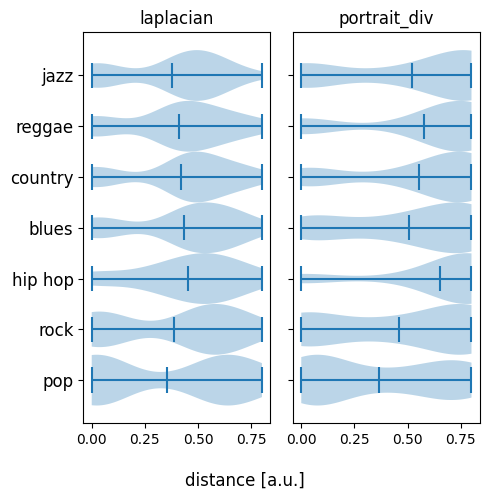

In [24]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5), sharey=True)
for method, ax in zip(METHODS, axes.ravel()):
    d = [min_max(data[i][method], a=0, b=0.8)
                 for i, _ in data.items()]
    ax.set_title(method)
    ax.violinplot(d, showmeans=True, widths=1, vert=False)
    ax.set_yticks(range(1, len(d)+1), 
                  labels=list(data.keys()), 
                  #rotation=70, 
                  fontsize=12)

fig.supxlabel("distance [a.u.]", fontsize=12)
plt.tight_layout()
plt.show()

**Figure 22:** Depicts the difference distances across genres for laplacian spectrum and portrait devergence. The bar in the middle of each violinplot indicates the mean.

Statistics across each genres showed a general difference for both methods (p < 0.01). Post hoc tests, revealed a multifaceted scenario (see Figure 22 for an pictorial summary); using normalized laplacian spectrum, pop music showed on average a higher similarity when compared to hip hop, blues, country, reggae and jazz (all p < 0.01), while rock showed a higher similarity compared to hip hop (p < 0.01); hip hop resulted in lower similarity as compared to blues, country and jazz (all p < 0.05). When using portrait divergence, no post hoc test survived the Bonferroni correction.

# Impact of similarity on Spotify streams

In order to assess whether lyrics homogeneity has any relationship with songs' success, I created a new dataset that comprised the songs common to both datasets. In this way it was possible to leverage on the lyrics of the first dataset and on the Spotify data from the second dataset. The main rationale behind this section is that if similar lyrics play any role on the number of Spotify streams, by creating a network of songs linked by lirics similarity, it should be possible to use a centrality metric in a regression model to assess the relationship with the number of streams of each song.

# Methods

## The Dataset

The dataset, called: `Spotify Top 10000 Streamed Songs` [11] is available on Kaggle, it reports 10000 songs with the relative number of Spotify streams, position in the Spotify chart and other features (see cell below). It was applied a light preprocessing to exclude duplicates, transform capitalized characters and delete missing data.

In [25]:
base_dir = "~/Documents/esami/economia_networks/project/dataset/archive/"
spotify_df = pd.read_csv(join(base_dir, "Spotify_final_dataset.csv"))

# rename columns as in the other dataframe
spotify_df.rename(columns={"Artist Name": "artist_name", "Song Name": "track_name"}, inplace=True)
spotify_df.artist_name = [i.strip() for i in spotify_df.artist_name]
# lower characters
spotify_df.artist_name = spotify_df.artist_name.str.lower()
spotify_df.track_name = spotify_df.track_name.str.lower()
# delete duplicates
spotify_df.drop_duplicates(subset=["artist_name", "track_name"], inplace=True)

## Creating the songs-network

The two datasets were unified by intersecting songs common to both datasets.
The resulting dataset contained primarily pop songs, hence the following analysis will focus only on this genre.

In order to test two different methods of assessing similarity, two methods were used to create the networks: 

1. I employed the set of words identified in the previous section of the project.

- Each song is a vertex.
- If two vertices share at least one word, an edge is created.
- The number of shared words are considered weights.

2. I computed the cosine similarity between lyrics: 

- Each song is a vertex.
- It is computed a pairwise cosine similarity between lyrics. If two songs reach a similarity of 0.1, an edge is created. 
- Cosine similarity is used as weights.


In [26]:
# find intersection between datasets and create song network

INTERS_DF = spotify_df.merge(df, how="inner", on=["artist_name", "track_name"])
INTERS_DF = INTERS_DF.loc[INTERS_DF.genre == "pop"]

# the character of the title bo$$ were not accepted by networkx
# thus I changed them into boss
INTERS_DF.track_name.loc[INTERS_DF.track_name == "bo$$"] = "boss"

# check for NaNs
NaNs = pd.DataFrame({"number_of_nan": INTERS_DF.isna().sum(),
            "perc_of_nan": INTERS_DF.isna().sum() / len(INTERS_DF) * 100})


### Create network of songs based on the words identified in the first section

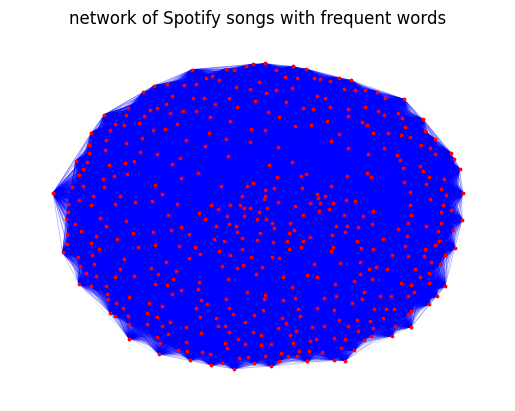

In [27]:
## previous way to create a network
WORDS_IN = {track: is_in_lyrics(lyrics, WORDS_DICT["pop"])
            for track, lyrics in zip(INTERS_DF.track_name, INTERS_DF.lyrics)}
  
NET = {"source":[], "target":[], "weight":[]}
for comb in combinations(list(WORDS_IN.keys()), 2):
    N_WORDS = len(is_in_lyrics(WORDS_IN[comb[0]], WORDS_IN[comb[1]]))
    if N_WORDS > 0:
        NET["source"].append(comb[0])
        NET["target"].append(comb[1])
        NET["weight"].append(N_WORDS)
DF_TRACKS = pd.DataFrame(NET)

TRACKS_NET = nx.from_pandas_edgelist(
                DF_TRACKS,
                source="source",
                target="target",
                edge_attr=True,
                create_using=nx.Graph()
            )

edges = TRACKS_NET.edges()
weights = [TRACKS_NET[u][v]["weight"] for u, v in edges]
pos = nx.kamada_kawai_layout(TRACKS_NET)

nx.draw_networkx_nodes(TRACKS_NET, 
                    pos, 
                    nodelist=None, 
                    node_size=3, 
                    node_color='red', 
                    node_shape='o', 
                    )

nx.draw_networkx_edges(
    TRACKS_NET, 
    pos, 
    edgelist=TRACKS_NET.edges(), 
    width=min_max(np.array(weights),a=0, b=1), 
    alpha=0.3, 
    edge_color="blue"
    )
plt.title("network of Spotify songs with frequent words")
plt.axis('off')
plt.show()

**Figure 23:** It depicts the graph of songs, red dots indicate songs, edges are weighted according to frequent words shared.

### Create newtork of songs based on cosine similarity

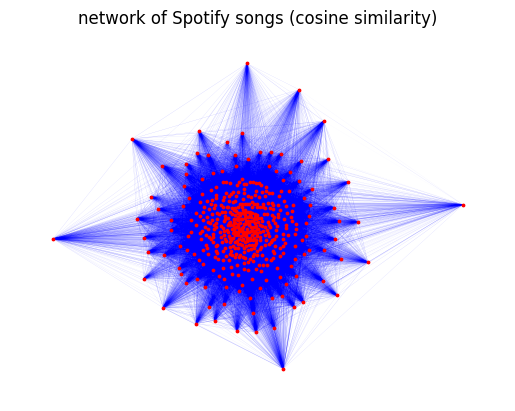

In [33]:
# compute cosine similarity between songs

corpus = INTERS_DF.lyrics.tolist()
vec = TfidfVectorizer()
vec_corpus = vec.fit_transform(corpus) 
cos_sim = cosine_similarity(vec_corpus)

# create dictionary fo the network

COS_CUTOFF = 0
SONGS_DICT = {"source":[], "target":[], "weight":[]}
for n, track in enumerate(INTERS_DF.track_name):
    cossim = cos_sim[n + 1:, n]
    ind = np.where(cossim > COS_CUTOFF)
    linked = INTERS_DF.track_name.values[n + 1:][ind[0]]
    SONGS_DICT["source"].extend([track]*len(linked))
    SONGS_DICT["target"].extend(linked)
    SONGS_DICT["weight"].extend(cossim[ind[0]])
    
SONGS_DF = pd.DataFrame(SONGS_DICT)

SONGS_NET = nx.from_pandas_edgelist(
                SONGS_DF,
                source="source",
                target="target",
                edge_attr=True,
                create_using=nx.Graph()
            )

edges = SONGS_NET.edges()
weights = [SONGS_NET[u][v]["weight"] for u, v in edges]
pos = nx.kamada_kawai_layout(SONGS_NET)
nx.draw_networkx_nodes(SONGS_NET, 
                    pos, 
                    nodelist=None, 
                    node_size=3, 
                    node_color='red', 
                    node_shape='o', 
                    )

nx.draw_networkx_edges(
    SONGS_NET, 
    pos, 
    edgelist=SONGS_NET.edges(), 
    width=min_max(np.array(weights),a=0, b=1), 
    alpha=0.3, 
    edge_color="blue"
    )
plt.title("network of Spotify songs (cosine similarity)")
plt.axis('off')
plt.savefig("network of Spotify songs.png")
plt.show()

**Figure 24:** It depicts the graph of songs, red dots indicate songs, edges are weighted according to cosine similarity.

## Predicting stream counts

In order to assess the impact of lyrics similarity on the number of streams, I extracted the eigenvector centrality of each node, given that this metric (together with the weights) should reflect similarity among songs in the network. I then used a Poisson regression to estimate the predicting power of similarity. The Poisson distribution was chosen given that counts was the dependent variable.
Prior to the regression, data were randomly split in training and test sets, the test set comprised the 25% of the data.
To assess the role of similarity I ran three different models:

1. `centrality` as unique regressor. 
2. `days` on the Spotify chart as unique regressor.
3. `centrality` and `days` as regressors.

The feature indicating the `days` spent in the chart was used to have also a comparative model with high predictive power. 
To evaluate the model I used the percentage of deviance explained, where 1 indicates the best model while values less than 1 indicate progressively worst models (it can have negative values).

In [29]:
def get_centrality_df(songs_net, orig_df):
    """
    """
    eigen_centr = nx.eigenvector_centrality(songs_net, weight="weight")

    stream = pd.DataFrame({"track_name": [song for song in eigen_centr.keys()], 
                 "centrality": [centr for centr in eigen_centr.values()]})

    stream_df = stream.merge(orig_df, how="inner", on="track_name")
    stream_df.rename(columns={"Total Streams": "total_streams",
                              "Days": "days"}, inplace=True)
    return stream_df


def poisson_model(y, x):
    """
    split data into training and test sets
    and runs a simple poisson regression
    
    Parameters
    ----------
    y : pandas dataframe 
    x : pandas dataframe
    
    Returns
    -------
    
    percentage of deviance explained : float
    predicted values : ndarray
    test values : ndarray
    """
    y_train, y_test, x_train, x_test = train_test_split(y, x, random_state=0)
    if len(x_train.shape) == 1:
        x_train = x_train.values.reshape(-1, 1)
        x_test = x_test.values.reshape(-1, 1)

    glm = PoissonRegressor(solver="newton-cholesky")
    glm.fit(x_train, y_train)
    y_pred = glm.predict(x_test)
    y_pred = y_pred.reshape(-1, 1)
    return glm.score(x_test, y_test, sample_weight=None), y_pred, y_test


### Poisson regression with frequent words

percentage of deviance explained for centrality: 0.0013573470345201732
percentage of deviance explained for days: 0.6586517190204126
percentage of deviance explained for ['centrality', 'days']: 0.6495517723174781


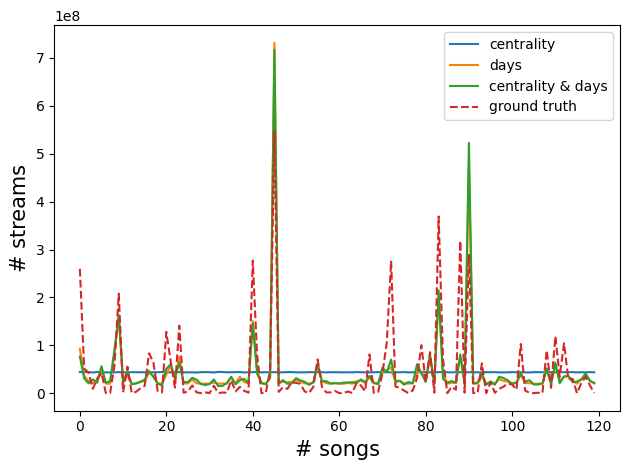

In [31]:
TRACKS_DF = get_centrality_df(TRACKS_NET, INTERS_DF)

for model in ["centrality", "days", ["centrality", "days"]]:
    score, y_pred, y_test = poisson_model(TRACKS_DF["total_streams"], 
                                          TRACKS_DF[model])
    print(f"percentage of deviance explained for {model}: {score}")
    plt.plot(y_pred)
    
plt.plot(np.array(y_test), "--")
plt.legend(["centrality", "days", "centrality & days", "ground truth"], fontsize=10)
plt.ylabel("# streams", fontsize=15)
plt.xlabel("# songs", fontsize=15)
plt.tight_layout()
plt.show()

**Figure 25:** It represents the predicted values according to the Poisson regression based on frequent words for different models:
centrality, days, centrality & days, ground truth. 

### Poisson regression with cosine similarity

percentage of deviance explained for centrality: 0.010317779751811917
percentage of deviance explained for days: 0.6664598589446904
percentage of deviance explained for ['centrality', 'days']: 0.6687605776277266


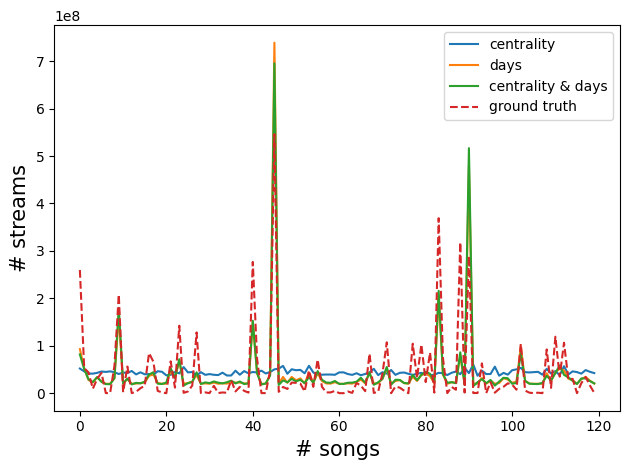

In [32]:
STREAM_DF = get_centrality_df(SONGS_NET, INTERS_DF)

for model in ["centrality", "days", ["centrality", "days"]]:
    y = STREAM_DF["total_streams"]
    x = STREAM_DF[model]
    score, y_pred, y_test = poisson_model(y, x)
    print(f"percentage of deviance explained for {model}: {score}")
    plt.plot(y_pred)
    
plt.plot(np.array(y_test), "--")
plt.legend(["centrality", "days", "centrality & days", "ground truth"], fontsize=10)
plt.ylabel("# streams", fontsize=15)
plt.xlabel("# songs", fontsize=15)
plt.tight_layout()
plt.savefig("Poisson_regression.png")
plt.show()

**Figure 26:** It represents the predicted values according to the Poisson regression based on cosine similarity for different models:
centrality, days, centrality & days, ground truth. 

# Results

As evident from figure 25 and 26, reults are virtually identical for both cosine similarity and frequent words approaches. The model closest to the ground truth is the centrality plus days model (freq. words: D = 0.65, cos. similarity: D = 0.67), however, the improvement over the days only model is extremely small (freq. words: D = 0.66, cos. similarity: D = 0.66). This is also shown by the low percentage of deviance explained for the centrality alone model (freq. words: D = 0.001, cos. similarity: D = 0.01). The centrality model does, indeed, a very poor job in predicting the stream counts compared to the other models, however, the cosine similarity seems to be slightly better than the frequent words model.

# Discussion

The project aimed at investigating whether lyrics in mainstream music have become more similar over time and whether such phenomenon, if present, plays role in songs' popularity on Spotify.
As highlighted in the previous paragraphs, I was able to identify a significant increase in similarity only in pop music between 1994 and 2016. However, no other genres showed such stable patterns.

The lack of other similar patterns and the huge fluctuation in all time series does not allow a univocal interpretation of the results.
On the one hand, it might be that the pattern observed in the pop time series corresponds to an actual phenomenon and that the other genres are simply characterized by strong fluctuations over the years, on the other hand such results might just be the biproduct of the methods adopted here and/or the rules adopted to create the graphs. 
The methods for graph comparison can indeed produce artifacts specific for each method (e.g. co-spectrality for the laplacian spectrum or the change in bins in portrait divergence, see [1] and [2]), hence providing unstable results.
Concerning the graph creation, a crucial issue can be identified in the topic modeling, which might have produced a set of words that did not capture enough topic diversity in mainstream music, hence only representing a subset of tracks for each genre.   

The general comparison among genres showed an average difference in similarity, which, as revealed by the post-hoc tests, was primarily driven by the difference between pop and the other genres. Pop networks seem, indeed, to show the higher degree of similarity with respect to other genres, although this result could be realistic, it is not completely in line with the hypothesis that genres like blues, reggae and country are less permeable to changes, thus resulting a stronger similarity. It is also crucial to consider that this result might be strongly driven by the abrupt change in pop music between 1994 and 2016, which is in line with recent studies [4].

Concerning the impact of similarity on Spotify streams, the results did not provide very little evidence for a role of lyrics similarity. This result was, however, rather predictable given that a variable like stream counts is most likely influenced by a huge number of variables.

In summary, the project was able to identify patterns supporting the increase homogeneity of mainstream lyrics in the last two decades and in particular in pop music. Potential future work, might adopt more sensitive methods, such as `word2vec` to extract the similarity, or graph neural networks to leverage on transformers and construct patterns related to the actual meaning of common words patterns.


# References


1. Wilson, R. C. & Zhu, P. A study of graph spectra for comparing graphs and trees. Pattern Recognition 41, 2833–2841 (2008).
2. An information-theoretic, all-scales approach to comparing networks | Applied Network Science | Full Text. https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0156-x.
3. Comparing methods for comparing networks | Scientific Reports. https://www.nature.com/articles/s41598-019-53708-y.
4. Schedl, M. Genre Differences of Song Lyrics and Artist Wikis: An Analysis of Popularity, Length, Repetitiveness, and Readability. in The World Wide Web Conference 3201–3207 (Association for Computing Machinery, 2019). doi:10.1145/3308558.3313604.
5. Percino, G., Klimek, P. & Thurner, S. Instrumentational Complexity of Music Genres and Why Simplicity Sells. PLOS ONE 9, e115255 (2014).
6. Moura, L., Fontelles, E., Sampaio, V. & França, M. Music Dataset: Lyrics and Metadata from 1950 to 2019. 3, (2020).
7. Yang, Y. “Musicalization of the Culture”: Is Music Becoming Louder, More Repetitive, Monotonous and Simpler? Proceedings of the International AAAI Conference on Web and Social Media 14, 750–761 (2020).
8. McCabe, S. et al. netrd: A library for network reconstruction and graph distances. Journal of Open Source Software 6, 2990 (2021).
9. Hartle, H. et al. Network comparison and the within-ensemble graph distance. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 476, 20190744 (2020).
10. Truong, C., Oudre, L. & Vayatis, N. Selective review of offline change point detection methods. Signal Processing 167, 107299 (2020).
11. Spotify Top 10000 Streamed Songs. https://www.kaggle.com/datasets/rakkesharv/spotify-top-10000-streamed-songs.
